# Visualize Result of PHILHARMONIC Analysis

In [8]:
# @title Download and Install PHILHARMONIC

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/samsledje/philharmonic.git
    !cd philharmonic; pip install -e .
    !curl https://current.geneontology.org/ontology/go.obo -o go.obo
    !curl https://current.geneontology.org/ontology/subsets/goslim_generic.obo -o goslim_generic.obo

from pathlib import Path

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from matplotlib import pyplot as plt

from philharmonic.utils import (
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
    plot_cluster,
    print_cluster,
    write_cluster_cytoscape,
)

In [39]:
# @title Loading PHILHARMONIC results
# @markdown Upload your zipped results file using the "Files" tab to the left.
# @markdown Set the `RUN_NAME` variable to the name of the run from your config file you want to analyze.
# @markdown If you are running this locally, edit the `RESULTS_DIR` variable to point to your results directory, and point to a locally downloaded go.obo file.

ZIP_FILE_NAME = ""  # @param {"type":"string","placeholder":"philharmonic_results.zip"}
# RUN_NAME = "20240926_cgoreaui"  # @param {"type":"string","placeholder":"philharmonic_run"}
RUN_NAME = "20240912-dmelaAll-phil_v0.2.0"
RESULTS_DIR = "."  # @param {"type":"string","placeholder":"."}

if IN_COLAB:
    from google.colab import files

    !unzip $ZIP_FILE_NAME
    results_dir = Path(".")
    GO_OBO_PATH = "go.obo"
else:
    # RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui/"
    RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0/"
    results_dir = Path(RESULTS_DIR)
    GO_OBO_PATH = results_dir / "go.obo"

CLUSTER_FILE_PATH = results_dir / f"{RUN_NAME}_clusters.json"
NETWORK_FILE_PATH = results_dir / f"{RUN_NAME}_network.positive.tsv"
GO_MAP_PATH = results_dir / f"{RUN_NAME}_GO_map.csv"
IMG_DIR = results_dir / "img"
!mkdir -p $IMG_DIR

clusters = load_cluster_json(CLUSTER_FILE_PATH)
full_G = nx.read_weighted_edgelist(NETWORK_FILE_PATH)
go_map = parse_GO_map(GO_MAP_PATH)
go_database = parse_GO_database(GO_OBO_PATH)

---

## Basic Network Statistics

In [40]:
label = ["Nodes", "Edges", "Degree (Med)", "Degree (Avg)", "Sparsity"]
degrees = [i[1] for i in list(full_G.degree())]
value = [
    len(full_G.nodes),
    len(full_G.edges),
    np.median(degrees),
    np.mean(degrees),
    len(full_G.edges()) / len(full_G) ** 2,
]
df = pd.DataFrame([label, value]).T
df.columns = ["", "Network"]
df = df.set_index("")
df

,Network
,
Nodes,4192
Edges,197510
Degree (Med),45.5
Degree (Avg),94.23187
Sparsity,0.011239


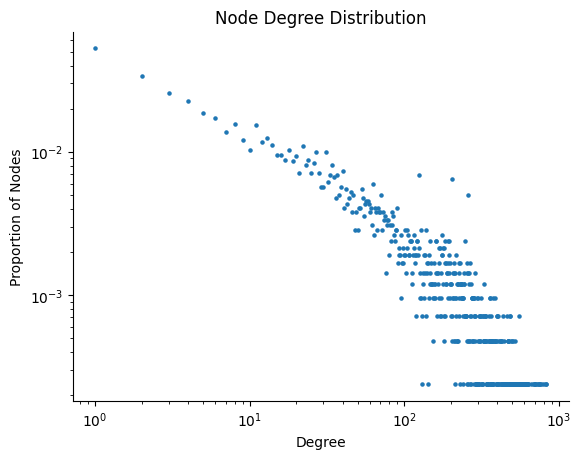

In [41]:
degreeDist = {}
for i in degrees:
    n = degreeDist.setdefault(i, 0)
    degreeDist[i] = n + 1

plt.scatter(degreeDist.keys(), [i / len(full_G) for i in degreeDist.values()], s=5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Proportion of Nodes")
plt.title("Node Degree Distribution")
plt.savefig(IMG_DIR / "degree_distribution.svg", bbox_inches="tight", dpi=300)
sns.despine()

---

## Basic Cluster Statistics

In [42]:
logger.info(f"Number of clusters: {len(clusters)}")

2024-10-21 20:26:57.301 | INFO     | __main__:<module>:1 - Number of clusters: 285


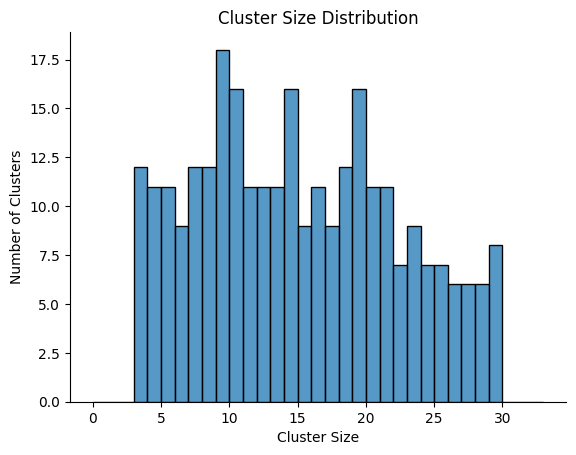

In [43]:
sizes = [len(i["members"]) for i in clusters.values()]
sns.histplot(sizes, bins=np.arange(0, max(sizes) + 5, max(sizes) // 20))
plt.xlabel("Cluster Size")
plt.ylabel("Number of Clusters")
plt.title("Cluster Size Distribution")
sns.despine()
plt.savefig(IMG_DIR / "size_distribution.svg", bbox_inches="tight", dpi=300)
plt.show()

---

## Overall ReCIPE Stats

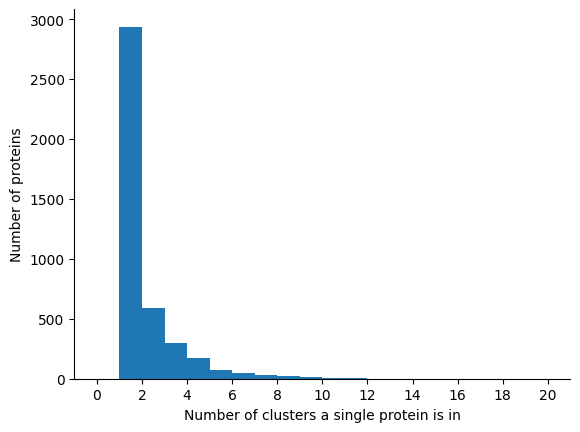

In [44]:
from collections import Counter

node_appearances = list()
for clust in clusters.values():
    for mn in clust["members"]:
        node_appearances.append(mn)
    for rn in clust["recipe"]["degree"]["0.75"]:
        node_appearances.append(rn)
nodes_counter = Counter(node_appearances)
plt.hist(nodes_counter.values(), bins=np.arange(0, 21, 1))
# xtick labels every 5
plt.xticks(np.arange(0, 21, 2))
plt.xlabel("Number of clusters a single protein is in")
plt.ylabel("Number of proteins")
sns.despine()
plt.savefig(IMG_DIR / "protein_number_of_clusters.png", bbox_inches="tight", dpi=300)
plt.show()

---

## View Individual Clusters

In [45]:
# k = "1495076087230339862" # Temperature Regulation
# k = "803905878821692717"  # Neurophysical Response

# k = "666417111483109151" # blue cluster
# k = "346047606648335785" # purple cluster

k = "1346451422620795471"

In [48]:
for m in sorted(clusters[k]["members"]):
    if "GO:0098869" in go_map[m]:
        print(m)

7227.FBpp0070550
7227.FBpp0072053
7227.FBpp0076643
7227.FBpp0085065
7227.FBpp0086741
7227.FBpp0087361
7227.FBpp0110121
7227.FBpp0291583
7227.FBpp0300610


Cluster of 9 proteins [7227.FBpp0085065, 7227.FBpp0086741, 7227.FBpp0110121, ...] (hash 1346451422620795471)
0 proteins re-added by ReCIPE (degree, 0.75)
Edges: 22
Triangles: 35
Max Degree: 6
Top Terms:
		GO:0007603 - <phototransduction, visible light> (7)
		GO:0060158 - <phospholipase C-activating dopamine receptor signaling pathway> (7)
		GO:0043950 - <positive regulation of cAMP-mediated signaling> (7)
		GO:0043547 - <positive regulation of GTPase activity> (7)
		GO:0071880 - <adenylate cyclase-activating adrenergic receptor signaling pathway> (7)
		GO:0010513 - <positive regulation of phosphatidylinositol biosynthetic process> (7)
		GO:0007191 - <adenylate cyclase-activating dopamine receptor signaling pathway> (7)
		GO:0007507 - <heart development> (7)
		GO:0071701 - <obsolete regulation of MAPK export from nucleus> (6)
		GO:0001789 - <sphingosine-1-phosphate receptor signaling pathway> (6)
		GO:0001822 - <kidney development> (6)
		GO:0021532 - <neural tube patterning> (6)
		GO:00

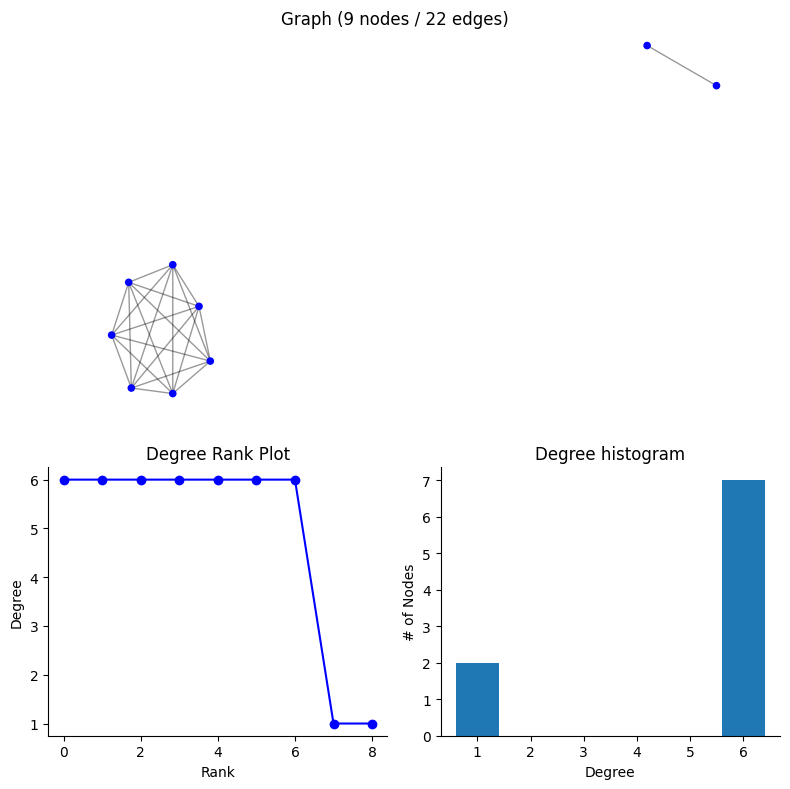

In [47]:
print_cluster(clusters[k], go_database, 20)
plot_cluster(clusters[k], full_G, use_recipe=True, savefig=None)

In [27]:
write_cluster_cytoscape(clusters[k], full_G, str(results_dir / f"{k}_cytoscape.txt"))